In [31]:
%load_ext autoreload
%autoreload 2
import jax
import jax.random as jr
import koopcore
import os, datetime
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
jax.config.update("jax_enable_x64", True)

In [33]:
DT = 0.1
STEPS = 14
N_TRAIN = 150
N_TEST = 50

D = 1000
params_base_kernel = {"name": "square-exponential", "p_kernel":{"scale":0.2}}

DEVICES = jax.devices("cpu")
LOAD_DATA = 0 # 
PRNGKey = jr.PRNGKey(44)
save_path = os.path.join("results", "van_der_pol_limit_cycle"+"_" +datetime.datetime.today().strftime('%Y-%m-%d'))

In [34]:
def generate_data(N, STEPS, PRNGKey):
    dynamical_system = koopcore.auxilliary.make_2d_ct_van_der_pol(*koopcore.auxilliary.params_van_der_pol_optimal_construction)
    initial_conditions = koopcore.auxilliary.sample_box(N, PRNGKey=PRNGKey)[0]
    return koopcore.auxilliary.get_gamma_ivp(STEPS, initial_conditions, dynamical_system, DT)
def generate_eigenvalues_dt(D, PRNGKey=jax.random.PRNGKey(0)):
    return koopcore.auxilliary.convert_2d_to_complex(koopcore.auxilliary.sample_disk(D, random=True, PRNGKey=PRNGKey)[0])

In [35]:
os.makedirs(save_path, exist_ok=True)

if LOAD_DATA:
    data_load = koopcore.auxilliary.load_trajectory_dict(os.path.join(save_path, "data.npz"))
    data_train = data_load["train"]
    data_test = data_load["test"]
else:
    PRNGKey, subkey = jr.split(PRNGKey)
    data = generate_data(N_TRAIN + N_TEST, STEPS, subkey)
    data_train = data.select_N([i for i in range(N_TRAIN)])
    data_test = data.select_N([i for i in range(N_TRAIN, N_TRAIN+N_TEST)])
    koopcore.auxilliary.save_trajectory_dict(os.path.join(save_path, "data"), train=data_train, test=data_test)

In [36]:
from sklearn.preprocessing import MinMaxScaler
PRNGKey, subkey = jr.split(PRNGKey)
KKR_model = koopcore.model.kkr_estimator.KoopmanKernelDTRegressor(
    eigenvalues=generate_eigenvalues_dt(D, subkey), 
    preprocessor=MinMaxScaler((-1, 1)),
    kernel_name=params_base_kernel["name"], 
    kernel_params=params_base_kernel["p_kernel"], 
    timestep=DT,
    device=DEVICES[0],
    regularizer_invariant=1e-8,
    regularizer_isometric=1e-8
    )

In [37]:
KKR_model.fit(data_train, data_train)
KKR_model.save(os.path.join(save_path, "KKR_model.pkl"))

In [38]:
prediction_train = KKR_model.predict(data_train.X[:, 0, :], STEPS)
prediction_test = KKR_model.predict(data_test.X[:, 0, :], STEPS)

In [39]:
plt_params={"linestyle":"dotted","linewidth":2,}

mean train loss: 0.00310649651743605
mean test loss:	 0.06527512866126518


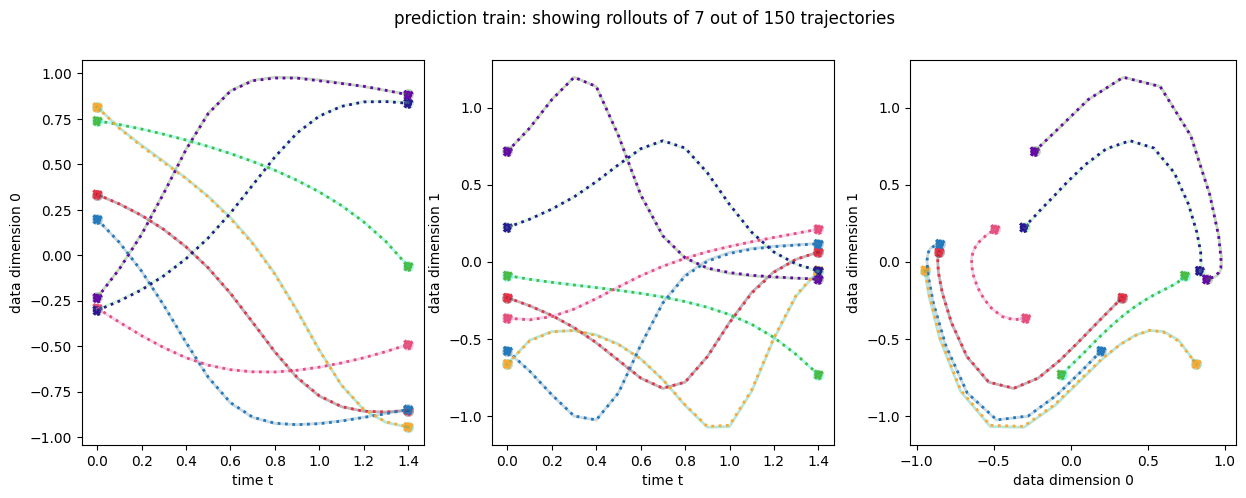

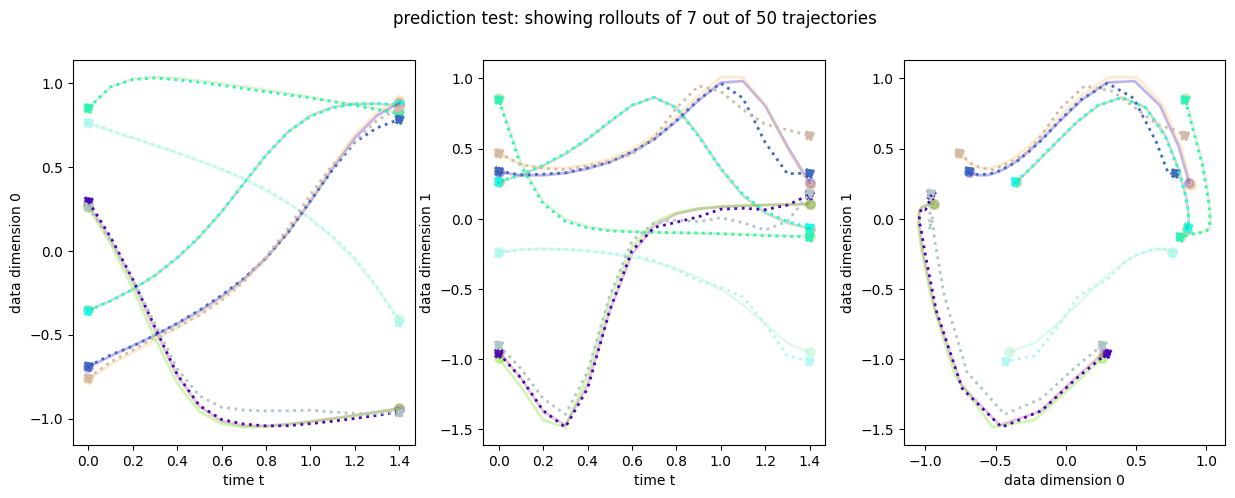

In [40]:
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TRAIN, [min(7, N_TRAIN)], replace=0)
f, _ = koopcore.auxilliary.plot_data( data_train, i_plot=i_plot, prepend_tag="data train", plt_params={"alpha":0.3,});
koopcore.auxilliary.plot_data( prediction_train, i_plot=i_plot, prepend_tag="prediction train", fig=f,plt_params={"linestyle":"dotted",});
plt.gca().set_aspect("equal")
PRNGKey, subkey = jr.split(PRNGKey, 2)
i_plot = jr.choice(subkey, N_TEST, [min(7, N_TEST)],  replace=0)
f, _ = koopcore.auxilliary.plot_data( data_test, i_plot=i_plot, prepend_tag="data test", plt_params={"alpha":0.3,});
koopcore.auxilliary.plot_data( prediction_test, i_plot=i_plot, prepend_tag="prediction test", fig=f, plt_params={"linestyle":"dotted"});
plt.gca().set_aspect("equal")
print("mean train loss: {}\nmean test loss:\t {}".format(
    koopcore.auxilliary.p_norm((data_train - prediction_train).X, a=[0, 1, 2], p=2),
    koopcore.auxilliary.p_norm((data_test  - prediction_test).X,  a=[0, 1, 2], p=2)))